In [1]:
from sklearn import datasets
import numpy as np

In [2]:
def load_iris():
    return datasets.load_iris()['data'].T, datasets.load_iris()['target']
def vcol(v):
    return v.reshape(v.size, 1)
def vrow(v):
    return v.reshape(1, v.size)

In [3]:
data, labels = load_iris()


In [4]:
data.shape

(4, 150)

In [5]:
def cov(D):
    mu = D.mean(axis=1)
    DC = D - vcol(mu)
    C = np.dot(DC, DC.T) / D.shape[1]
    return C

In [6]:
def PCA(D, n):
    C = cov(D)
    _, U = np.linalg.eigh(C)
    P = U[:, ::-1][:, 0:n]
    DP = np.dot(P.T, D)
    return DP, U

In [7]:
result, _ = PCA(data, 2)

In [8]:
import matplotlib.pyplot as plt
def plot_iris(result, target):
    plt.scatter(result[0, target==0], result[1, target==0], label='Setosa')
    plt.scatter(result[0, target==1], result[1, target==1], label='Versicolor')
    plt.scatter(result[0, target==2], result[1, target==2], label='Virginica')
    plt.legend()
    plt.show()

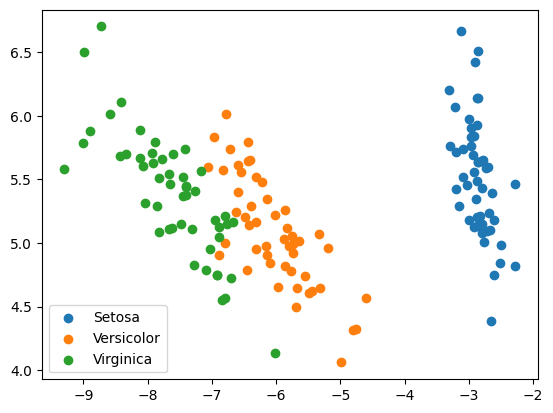

In [9]:
plot_iris(result, labels)

In [10]:
data0 = data[:, labels==0]
data1 = data[:, labels==1]
data2 = data[:, labels==2]

In [11]:
C0 = cov(data0)
C1 = cov(data1)
C2 = cov(data2)

In [12]:
def within_cov(D, labels):
    classes = set(labels)
    C = np.zeros((D.shape[0], D.shape[0]))
    for class_ in classes:
        Dc = D[:, labels==class_]
        mu_c = Dc.mean(axis=1)
        Dc -= vcol(mu_c)
        C += np.dot(Dc, Dc.T)
    return C/D.shape[1]
        

def between_cov(D, labels):
    classes = set(labels)
    mu = D.mean(axis=1)
    C = np.zeros((D.shape[0], D.shape[0]))
    for class_ in classes:
        Dc = D[:, labels==class_]
        mu_c = Dc.mean(axis=1)
        C += Dc.shape[1] * np.dot(vcol(mu_c-mu), vcol(mu_c-mu).T)
    return C/D.shape[1]

In [13]:
SW = within_cov(data, labels) 
SB = between_cov(data, labels)

In [14]:
import scipy.linalg

In [15]:
s, U = scipy.linalg.eigh(SB, SW)
m = 2
W = U[:, ::-1][:, 0:m]
lda_result = np.dot(W.T, data)

In [16]:
solution = np.load("IRIS_LDA_matrix_m2.npy")

In [17]:
W, solution

(array([[ 0.83779794,  0.02434685],
        [ 1.55005187,  2.18649663],
        [-2.22355955, -0.94138258],
        [-2.83899363,  2.86801283]]),
 array([[ 0.83779794,  0.02434685],
        [ 1.55005187,  2.18649663],
        [-2.22355955, -0.94138258],
        [-2.83899363,  2.86801283]]))

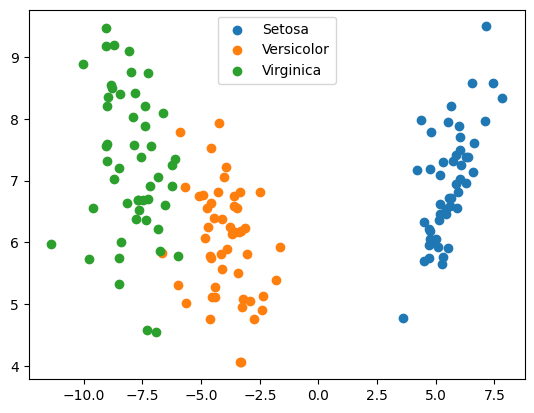

In [18]:
plot_iris(lda_result, labels)

# Binary Classification

In [19]:
def lda(D, labels, m):
    SW = within_cov(D, labels)
    SB = between_cov(D, labels)
    _, U = scipy.linalg.eigh(SB, SW)
    W = U[:, ::-1][:, 0:m]
    return np.dot(W.T, D), W

In [20]:
b_data = data[:, labels!=0]
b_labels = labels[labels!=0]
b_data.shape, b_labels.shape

((4, 100), (100,))

In [21]:
def split(D, L, seed = 0):
    nTrain = int(D.shape[1]*2.0/3.0)
    np.random.seed(seed)
    idx = np.random.permutation(D.shape[1])
    idxTrain = idx[0:nTrain]
    idxTest = idx[nTrain:]
    DTR = D[:, idxTrain]
    DVAL = D[:, idxTest]
    LTR = L[idxTrain]
    LVAL = L[idxTest]
    return (DTR, LTR), (DVAL, LVAL)

In [22]:
(DTR, LTR), (DVAL, LVAL) = split(b_data, b_labels)

In [23]:
DTR.shape, LTR.shape, DVAL.shape, LVAL.shape

((4, 66), (66,), (4, 34), (34,))

In [24]:
DTR_lda, W = lda(DTR, LTR, 1)

In [25]:
W

array([[-0.88381021],
       [-1.56103706],
       [ 1.46175793],
       [ 4.051348  ]])

In [26]:
threshold = ((DTR_lda[0, LTR==1].mean() + DTR_lda[0, LTR==2].mean()) / 2.0)

In [27]:
threshold

4.078616922547409

In [28]:
DVAL_lda = np.dot(W.T, DVAL)

In [29]:

PVAL = np.zeros(shape=LVAL.shape, dtype=np.int32)
PVAL[DVAL_lda[0] >= threshold] = 2
PVAL[DVAL_lda[0] < threshold] = 1

In [30]:
PVAL, LVAL

(array([1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1,
        2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1], dtype=int32),
 array([1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1,
        2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1]))

In [31]:
#compute accuracy
def accuracy(P, L):
    return np.sum(P == L) / float(L.size), P.size - np.sum(P == L)
accuracy(PVAL, LVAL)

(0.9411764705882353, 2)

In [52]:
def binary_classification(D, L, m, pca = True):
    (DTR, LTR), (DVAL, LVAL) = split(D[:, L!=0], L[L!=0])
    if pca:
        DTR, U = PCA(DTR, m)
        P = U[:, ::-1][:, 0:m]
        DVAL = np.dot(P.T, DVAL)
    
    DTRP_lda, W = lda(DTR, LTR, 1)
    
    mean_class_1 = DTRP_lda[0, LTR==1].mean()
    mean_class_2 = DTRP_lda[0, LTR==2].mean()
    
    if mean_class_1 > mean_class_2:
        W = -W  
    threshold = (mean_class_1 + mean_class_2) / 2

    DVALP_lda = np.dot(W.T, DVAL)
    
    PVAL = np.zeros(shape=LVAL.shape, dtype=np.int32)
    PVAL[DVALP_lda[0] >= threshold] = 2
    PVAL[DVALP_lda[0] < threshold] = 1
    return accuracy(PVAL, LVAL)

In [53]:
def pca_lda(D, L, m):
    (DTR, LTR), (DVAL, LVAL) = split(D[:, L!=0], L[L!=0])
    DTRP, U = PCA(DTR, m)
    DTRP_lda, W = lda(DTRP, LTR, 1)
    
    P = U[:, ::-1][:, 0:m]
    DVALP = np.dot(P.T, DVAL)
    
    mean_class_1 = DTRP_lda[0, LTR==1].mean()
    mean_class_2 = DTRP_lda[0, LTR==2].mean()
    
    if mean_class_1 > mean_class_2:
        W = -W  
    threshold = (mean_class_1 + mean_class_2) / 2

    DVALP_lda = np.dot(W.T, DVALP)
    PVAL = np.zeros(shape=LVAL.shape, dtype=np.int32)
    PVAL[DVALP_lda[0] >= threshold] = 2
    PVAL[DVALP_lda[0] < threshold] = 1
    return accuracy(PVAL, LVAL)

In [54]:
pca_lda(data, labels, 4), pca_lda(data, labels, 3), pca_lda(data, labels, 2)

((0.5294117647058824, 16), (0.5294117647058824, 16), (0.9411764705882353, 2))

In [57]:
binary_classification(data, labels, 4, False), binary_classification(data, labels, 3), binary_classification(data, labels, 2)

((0.9411764705882353, 2), (0.5294117647058824, 16), (0.9411764705882353, 2))

In [34]:
def plot_hist(feature, labels, bins=10):
    l = ["1", "2"]
    plt.hist(feature[labels == 1].flatten(), alpha=0.5, label=l[0], bins=bins, density=True)
    plt.hist(feature[labels == 2].flatten(), alpha=0.5, label=l[1], bins=bins, density=True)
    plt.legend()
    plt.show()

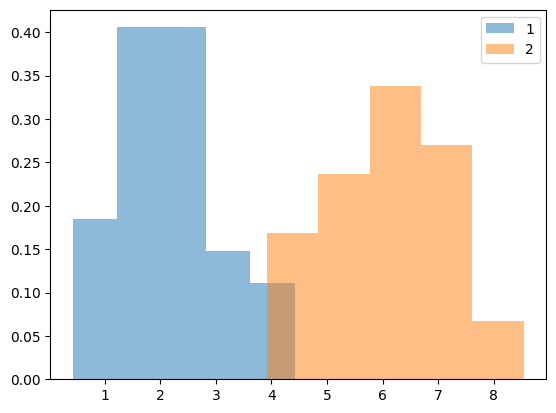

In [35]:
plot_hist(DTR_lda[0], LTR, 5)

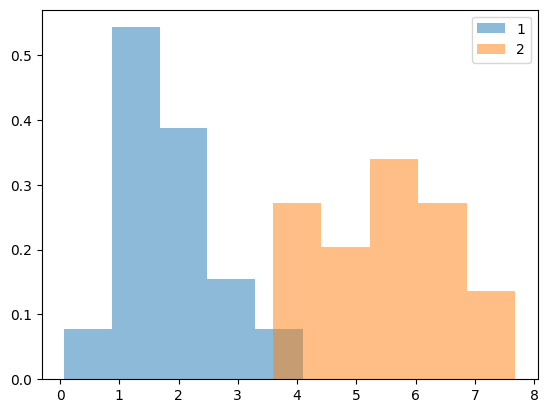

In [36]:
DVAL_lda = np.dot(W.T, DVAL)
plot_hist(DVAL_lda[0], LVAL, 5)